In [432]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import DiaSourceTools as DSTools
import lsst.afw.display.utils as displayUtils
import lsst.meas.algorithms.detection as sDet

%matplotlib inline

In [305]:
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_v11/"
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")

subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass
            


In [423]:
dataId = {'visit': 800719, 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)
sciExp  = butler.get("calexp", {"visit":800719, "ccd":14, "filter":"r"})
tmpExp = butler.get("deepDiff_warpedExp", {"visit":800719, "ccd":14, "filter":"r"})
bgConf = sDet.BackgroundConfig()
background,tmpExp = sDet.estimateBackground(tmpExp,bgConf,True)

In [307]:

diff_stamp = DSTools.get_stamp(ds, diffExp)
sci_stamp = DSTools.get_stamp(ds, sciExp)
tmp_stamp = DSTools.get_stamp(ds, tmpExp)


In [308]:
im = displayUtils.Mosaic(gutter=5, background=5, mode="x")
im.append(sci_stamp.getMaskedImage())
im.append(tmp_stamp.getMaskedImage())
im.append(diff_stamp.getMaskedImage())
im.makeMosaic(frame=4, title="mosaic")

<lsst.afw.image.imageLib.MaskedImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::MaskedImage< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7fdfcd785900> >

In [309]:
fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_CircularApertureFlux_6_0_flux")

In [310]:
m_sigma = np.mean(sigmas)
t_sigma = 5*m_sigma

In [426]:
reload(DSTools)

<module 'DiaSourceTools' from 'DiaSourceTools.py'>

In [312]:
sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_CircularApertureFlux_6_0_flux")

In [313]:
ds9.mtv(tmpExp)

In [424]:
mosaic_dif = displayUtils.Mosaic(gutter=5, background=3, mode="square")
mosaic_sci = displayUtils.Mosaic(gutter=5, background=3, mode="square")
mosaic_tmp = displayUtils.Mosaic(gutter=5, background=3, mode="square")

for i, source in enumerate(sources):
    try:
        dif_stamp = DSTools.get_stamp(source, diffExp)
        
        negFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_neg_flux"))
        posFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_pos_flux"))
        totalFlux=negFlux+posFlux
        passesFluxNeg = (negFlux / totalFlux)
        passesFluxPos = (posFlux / totalFlux)
        
        mosaic_dif.append(dif_stamp.getMaskedImage(), label=str(i)+"-"+str(source.get("classification_dipole")))
        
        sci_stamp = DSTools.get_stamp(source, sciExp)
        mosaic_sci.append(sci_stamp.getMaskedImage(), label=str(i))

        
        tmp_stamp = DSTools.get_stamp(source, tmpExp)
        mosaic_tmp.append(tmp_stamp.getMaskedImage(), label=str(i))
    except Exception, e:
        print e


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612'



In [425]:
mosaic_dif.makeMosaic(frame=1, title="mosaic_dif")
ds9.setMaskTransparency(100, frame=1)
mosaic_sci.makeMosaic(frame=2, title="mosaic_science")
ds9.setMaskTransparency(100, frame=2)
mosaic_tmp.makeMosaic(frame=3, title="mosaic_template")
ds9.setMaskTransparency(100, frame=3)

In [68]:
ds = sources[0]

In [71]:
ds.get("ip_diffim_NaiveDipoleCentroid_x")

414.459228515625

In [439]:
positive_mask = []
negative_mask = []
mosaic_dif = displayUtils.Mosaic(gutter=5, background=3, mode="square")

label = ""
for source in sources:
    try:
        dif_stamp = DSTools.get_stamp(source, diffExp)

        mi = dif_stamp.getMaskedImage()
        mask = mi.getMask()


        bitmask_detected = mask.getPlaneBitMask("DETECTED")
        bitmask_detected_neg = mask.getPlaneBitMask("DETECTED_NEGATIVE")

        for x in range(0, mi.getWidth()):
            for y in range (0, mi.getHeight()):
                u =  mi.getMask()[x,y]

                if u.get(0,0) & bitmask_detected != 0 and u.get(0,0):
                        positive_mask.append(mi.getImage().get(x,y))
                elif u.get(0,0) & bitmask_detected_neg != 0 and u.get(0,0):
                        negative_mask.append(mi.getImage().get(x,y))

        positive_flux = np.sum(positive_mask)
        negative_flux = np.abs(np.sum(negative_mask))
        total_flux = positive_flux+negative_flux
        print "=========source============"
        print positive_flux/total_flux, negative_flux/total_flux, positive_flux/total_flux + negative_flux/total_flux
        print positive_flux, negative_flux, total_flux
        print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), np.abs(source.get("ip_diffim_PsfDipoleFlux_neg_flux"))
        print source.get("ip_diffim_NaiveDipoleCentroid_x"), source.get("ip_diffim_NaiveDipoleCentroid_y")
        print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y")
        print source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
        
        if positive_flux/total_flux < 0.65 and negative_flux/total_flux < 0.65:
            label += "dipole"

        mosaic_dif.append(mi, label=label)

    except Exception, e:
        print e
mosaic_dif.makeMosaic(frame=4, title="mosaic_dif_corrected")
ds9.setMaskTransparency(100, frame=4)

=========source============
0.192442720586 0.807557279414 1.0
1993.54454803 8365.61344956 10359.1579976
7624.72743915 12746.2383982
414.459228516 34.1615562439
418.897766113 24.1649017334
410.020721436 44.1582107544
=========source============
0.723699588889 0.276300411111 1.0
205100.671146 78305.1429448 283405.814091
143773.383137 164699.895497
103.003456116 128.702178955
103.003456116 128.702178955
nan nan
=========source============
0.730332307919 0.269667692081 1.0
211387.315759 78052.5918927 289439.907652
182277.786818 211299.378058
1243.97680664 146.918212891
1243.97680664 146.918212891
nan nan
=========source============
0.843178101771 0.156821898229 1.0
420530.720812 78214.1113042 498744.832117
nan nan
698.862304688 278.428497314
698.821411133 276.105987549
698.903137207 280.75100708
=========source============
0.843044547515 0.156955452485 1.0
424854.139954 79098.0428891 503952.182843
5249.21592579 1213.90352813
510.371948242 314.905639648
509.823303223 319.034545898
510.92062

In [349]:
from lsst.meas.base import SingleFrameMeasurementTask
import lsst.afw.geom as afwGeom
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.ip.diffim import DipoleMeasurementTask

In [362]:
source = sources[13]
dif_stamp = DSTools.get_stamp(source, diffExp)
ds9.mtv(dif_stamp, frame=6)

# DIASource detection and measurement

This code replicates the basic process of detecting a DIASource on a subtracted image using the SourceDetectionTask. In order to get the dipole lobe detection, attribute thresholdPolarity should be set to "both". Next step is to measure such detections (which includes dipoles) in order to get the Fluxes, Sigma and Centroids of all the sources (using the Naive, PSF and Ap Methods).

In [428]:
#test_stamp = dif_stamp.clone()
mosaic_corr_dif = displayUtils.Mosaic(gutter=5, background=3, mode="square")

for source in sources:
    try:
        test_stamp = DSTools.get_stamp(source, diffExp)
        test_stamp = test_stamp.clone()

        mask  = test_stamp.getMaskedImage().getMask()
        mask &= ~(mask.getPlaneBitMask("DETECTED") | mask.getPlaneBitMask("DETECTED_NEGATIVE"))

        schema = afwTable.SourceTable.makeMinimalSchema()

        #DipoleMeasurementTask.algorithms.names.add('base_PeakLikelihoodFlux')
        DMTask = DipoleMeasurementTask(schema=schema, algMetadata=algMetadata)

        table = afwTable.SourceTable.make(schema)

        config = SourceDetectionTask.ConfigClass()
        config.thresholdPolarity = "both"
        config.thresholdValue = 5.5
        config.reEstimateBackground = False
        config.thresholdType = "pixel_stdev"



        detectionTask = SourceDetectionTask(config=config, schema=schema)

        table = afwTable.SourceTable.make(schema)
        #sources = detectionTask.run(table, exposure, sigma=2).sources
        results = detectionTask.makeSourceCatalog(table=table, exposure=test_stamp , doSmooth=not False )
        DMTask.run(results.sources, test_stamp)


        mosaic_corr_dif.append(test_stamp.getMaskedImage(), label = str(DSTools.get_naive_dipole_probability(source)))
    except Exception, e:
        print e

mosaic_corr_dif.makeMosaic(frame=6, title="mosaic_dif_corrected")
ds9.setMaskTransparency(100, frame=6)


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612'



In [375]:
for s in results.sources:
    flag = s.get("classification_dipole")
    pos = s.get("ip_diffim_PsfDipoleFlux_pos_flux")
    neg = np.abs(s.get("ip_diffim_PsfDipoleFlux_neg_flux"))
    tot = pos+neg
    pos_per = pos/tot
    neg_per = neg/tot
    print flag, pos, neg, tot, pos_per, neg_per

0.0 nan nan nan nan nan
0.0 nan nan nan nan nan


Utility to remove a mask from a stamp and then visualize it.

In [ ]:
# mask  = test_stamp.getMaskedImage().getMask()
mask &= ~(mask.getPlaneBitMask("SAT"))
mask &= ~(mask.getPlaneBitMask("INTRP"))


ds9.mtv(test_stamp, frame=7)

# Detected Objects Study

In [445]:
total = len(sources)
dipoles = 0
nan_dipoles = 0
nan_non_dipoles = 0

naive_dipoles = 0
nan_naive_dipoles = 0
nan_non_naive_dipoles = 0

for s in sources:
        if s.get("classification_dipole") == 1:
            dipoles += 1
            if np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
                nan_dipoles+=1
        elif np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
            nan_non_dipoles += 1
            
        if DSTools.get_naive_dipole_probability(s) > 0:
            naive_dipoles += 1
            if np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
                nan_naive_dipoles+=1
        elif np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
            nan_non_naive_dipoles +=1
            

In [446]:
print total, dipoles, nan_dipoles, nan_non_dipoles
print total, naive_dipoles, nan_naive_dipoles, nan_non_naive_dipoles

24 5 0 10
24 11 4 6


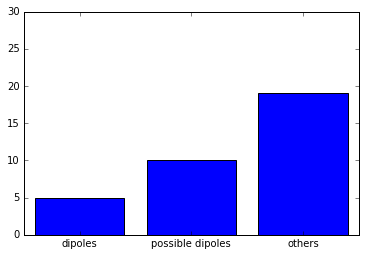

In [495]:
psf_flux_data = [dipoles, nan_non_dipoles, total-(dipoles+nan_dipoles)]
labels = ('dipoles', 'possible dipoles','others')

ind = np.arange(len(psf_flux_data))

plt.bar(ind, psf_flux_data, align='center')
ax = plt.axes()



plt.xticks(ind, labels)
plt.yticks(np.arange(0, total+10, 5))

plt.show()

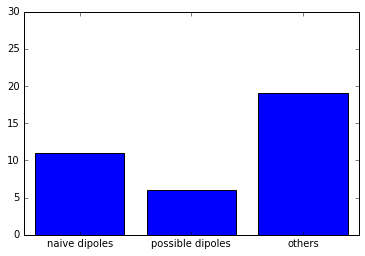

In [496]:
psf_flux_data = [naive_dipoles, nan_non_naive_dipoles, total-(dipoles+nan_dipoles)]
labels = ('naive dipoles', 'possible dipoles','others')

ind = np.arange(len(psf_flux_data))

plt.bar(ind, psf_flux_data, align='center')
ax = plt.axes()

plt.xticks(ind, labels)

plt.yticks(np.arange(0, total+10, 5))

plt.show()

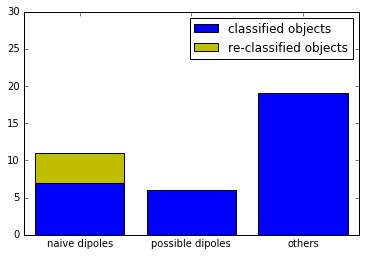

In [503]:
psf_flux_data = [naive_dipoles-nan_naive_dipoles, nan_non_naive_dipoles, total-(dipoles+nan_dipoles)]
psf_flux_extra_data = [nan_naive_dipoles, 0, 0]

labels = ('naive dipoles', 'possible dipoles','others')

ind = np.arange(len(psf_flux_data))

p1 = plt.bar(ind, psf_flux_data, align='center')
ax = plt.axes()




p2 =plt.bar(ind, psf_flux_extra_data, color='y', align='center', bottom=psf_flux_data)
plt.xticks(ind, labels)
plt.legend((p1[0], p2[0]), ('classified objects','re-classified objects'))
plt.yticks(np.arange(0, total+10, 5))
plt.title("")
plt.show()